### A/B testing

[Data](https://www.kaggle.com/dhimananubhav/a-b-testing) is the comparation between old and new pages. 
To test our hypothesis, we use A/B testing. It is a variation of a permutation test. 
Under the null hypothesis, there should be no difference of the conversion whether the user saw the old page or the new page. That's because the null hypothesis states that both two group are simple random samples from the same distribution. [Useful material](https://classroom.udacity.com/courses/ud257) for understanding AB testing. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [51]:
data = pd.read_csv('ab_data.csv')

In [52]:
print('data shape',data.shape)
print('user_id',data.user_id.nunique())
data.info()

data shape (294478, 5)
user_id 290584
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [53]:
data.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


__Duplicated_User_ID__

In [54]:
data[data.user_id.duplicated()].head()

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0


In [55]:
data[data['user_id'] == 664347]

,user_id,timestamp,group,landing_page,converted
17520,664347,2017-01-12 11:53:38.093505,treatment,old_page,0
20019,664347,2017-01-16 05:24:04.119117,control,old_page,0


__Treatment Group: New Page__  
__Control Group: Old Page__ 

For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. These rows need to be dropped.

In [56]:
drop = data[(data['group'] == 'control') & (data['landing_page'] == 'new_page') \
            | (data['group'] == 'treatment') & (data['landing_page'] == 'old_page')]

In [57]:
print('num of rows that do not obey the law', len(drop))

num of rows that do not obey the law 3893


In [58]:
df_new = data[~data.isin(drop)].dropna().reset_index()

In [59]:
print('dataset after removing those do not obey the law', len(df_new))
df_new[df_new.user_id.duplicated()].head()

dataset after removing those do not obey the law 290585


,index,user_id,timestamp,group,landing_page,converted
2862,2893,773192.0,2017-01-14 02:55:59.590927,treatment,new_page,0.0


In [60]:
df_new[df_new['user_id'] == 773192.0]

,index,user_id,timestamp,group,landing_page,converted
1876,1899,773192.0,2017-01-09 05:37:58.781806,treatment,new_page,0.0
2862,2893,773192.0,2017-01-14 02:55:59.590927,treatment,new_page,0.0


In [61]:
df_new = df_new.drop(df_new.index[1899]).reset_index()

In [62]:
print('min time interval',min(pd.to_datetime(df_new['timestamp'])))
print('max time interval',max(pd.to_datetime(df_new['timestamp'])))

min time interval 2017-01-02 13:42:05.378582
max time interval 2017-01-24 13:41:54.460509


### Control and Treatment Group 
1. Calculate Probablities 
2. [Binomial Distribution](https://en.wikipedia.org/wiki/Binomial_distribution) 

In [63]:
df_control = df_new[df_new['group'] == 'control']
df_treatment = df_new[df_new['group'] == 'treatment']

In [64]:
print('control group', len(df_control))
print('treatment group',len(df_treatment))

control group 145273
treatment group 145311


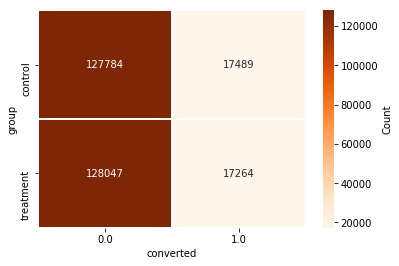

In [65]:
sns.heatmap(pd.crosstab(df_new['group'], df_new['converted']),
            annot=True, linewidths=.5, fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})

### Z score for two binomial distribution 

<img src="image.png" width="500" height="500" /> 

In [66]:
n_control = len(df_control)
n_treatment = len(df_treatment)

In [67]:
p1 = sum(df_control['converted'])/n_control
p2 = sum(df_treatment['converted'])/n_treatment

In [68]:
p = sum(df_new['converted'])/len(df_new)

In [69]:
# sampling error 
se = np.sqrt(p1*(1-p1)/len(df_control)+p2*(1-p2)/len(df_treatment))

In [70]:
Z = (p1-p2)/se
Z

1.312294565754967

In [71]:
p_diffs=[]
p_diffs = np.random.binomial(n_treatment, p, 10000)/n_treatment - np.random.binomial(n_control, p, 10000)/n_control   

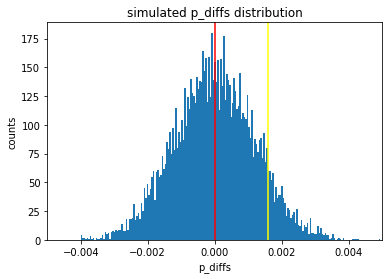

In [75]:
plt.hist(p_diffs, bins=200)
plt.xlim(-0.005, 0.005)
plt.xlabel('p_diffs')
plt.ylabel('counts')
plt.title('simulated p_diffs distribution')
plt.axvline(0.000, color='red')
plt.axvline(p1-p2, color='yellow')

In [78]:
from scipy.stats import norm
# Tells us how significant our z-score is
print(norm.cdf(Z))

0.9052896174952674


Zscore is 1.31 and P value is 1-0.9=0.1, larger than alpha 0.05. 
Therefore based on z-score and p value I fail to reject the null hypothesis that the new page and old page are not different in leading the conversion rate.  